![header](https://i.imgur.com/zAXQLhR.jpeg)
# **Predicción de Demanda de Productos mediante Machine Learning**

### **Introducción**
El presente proyecto tiene como objetivo desarrollar un modelo predictivo de ventas utilizando técnicas de Machine Learning para anticipar la demanda de productos en múltiples tiendas. La capacidad de predecir con precisión las ventas futuras es fundamental para optimizar la gestión de inventarios, mejorar la planificación operativa y maximizar la rentabilidad del negocio.

### **Objetivo del Proyecto**
El objetivo principal es predecir las ventas de los próximos 31 días a partir de la última fecha disponible en el dataset del Store Item Demand Forecasting Challenge de Kaggle. Este dataset contiene información histórica de ventas de diferentes productos en distintas tiendas, proporcionando un escenario ideal para aplicar y evaluar modelos de series temporales y algoritmos de aprendizaje automático.

### **Metodología**
El desarrollo del proyecto se estructura en las siguientes etapas:

* **Análisis Exploratorio de Datos (EDA)**: Exploración y visualización del dataset para identificar patrones, tendencias, estacionalidad y posibles anomalías en las series temporales de ventas.

* **Preparación de Datos**: Limpieza, transformación y generación de características (feature engineering) relevantes para mejorar el desempeño del modelo predictivo.

* **Modelado con Machine Learning**: Implementación y evaluación de un algoritmo de ML especializado en forecasting, considerando la naturaleza temporal de los datos.

* **Evaluación del Modelo**: Análisis del rendimiento mediante métricas apropiadas para problemas de regresión y series temporales.

* **Visualización en Tableau**: Desarrollo de un dashboard interactivo que presente tanto estadísticas descriptivas del dataset como las predicciones generadas por el modelo, facilitando la interpretación de resultados y la toma de decisiones.

### **Enlaces**
* [Dashboard con predicción en Tableau Public](https://public.tableau.com/views/DemandSalesForecasting/Dashboard?:showVizHome=no&:embed=yes&:toolbar=no&:tabs=no&:display_count=no)

* [Competición de Kaggle con el dataset](https://www.kaggle.com/competitions/demand-forecasting-kernels-only)

---
### Imports

In [27]:
from util import (
    kaggle_setup,           # Script personalizado para descarga desde Kaggle
    dataframe_summary,      # Script personalizado para sumario de dataset
    forecasting_fe,         # Script personalizado para feature engineering
    validation_dashboard,   # Script personalizado para dashboard con resultados
    future_predictions      # Script personalizado para generar predicciones a futuro
)

import zipfile, joblib, pickle
from pathlib import Path
from IPython.display import Image, display
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore') 


### Configuración de credenciales de Kaggle

In [28]:
kaggle_setup.setup_kaggle_credentials()

✅ kaggle.json already configured


### Descarga de los datos

In [29]:
# Download
data_dir = Path('dataset')
download_link = 'kaggle competitions download -c demand-forecasting-kernels-only -p ./dataset'
kaggle_setup.download_data(data_dir, download_link)

# Unzip
zip_file = data_dir / 'demand-forecasting-kernels-only.zip'
if zip_file.exists():
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    zip_file.unlink()

✅ dataset already downloaded


### Datasets

In [30]:
train_df = pd.DataFrame(pd.read_csv(data_dir/'train.csv'))
test_df = pd.DataFrame(pd.read_csv(data_dir/'test.csv'))
sample_submission_df = pd.DataFrame(pd.read_csv(data_dir/'sample_submission.csv'))

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])


### Sumario del dataset de entrenamiento

In [31]:
dataframe_summary.print_dataframe_summary(train_df, 'Train')

                          COMPREHENSIVE SUMMARY: Train                          

────────────────────────────────────────────────────────────────────────────────
📊 BASIC INFORMATION
────────────────────────────────────────────────────────────────────────────────
Shape: 913,000 rows × 4 columns
Memory Usage: 27.86 MB
Duplicate Rows: 0 (0.00%)

────────────────────────────────────────────────────────────────────────────────
📋 COLUMNS AND DATA TYPES
────────────────────────────────────────────────────────────────────────────────
  • int64: 3 column(s)
  • datetime64[ns]: 1 column(s)

Column List: date, store, item, sales

────────────────────────────────────────────────────────────────────────────────
❌ MISSING VALUES
────────────────────────────────────────────────────────────────────────────────
✓ No missing values found!

────────────────────────────────────────────────────────────────────────────────
🔍 FIRST 5 ROWS
─────────────────────────────────────────────────────────────────────

### Dashboard con los resultados del análisis exploratorio

Estas imágenes fueron realizadas en la plataforma *Canva* con gráficos generados previamente en esta Notebook.

In [32]:
display(Image(url='https://i.imgur.com/Aba5YJI.jpeg', width=1000))
display(Image(url='https://i.imgur.com/uZ5GA02.jpeg', width=1000))

### Modelo benchmark base
El siguiente es un modelo benchmark base.
1. Se dividen los datos de entrenamiento en dos partes especificando una fecha de corte (ya que en series temporales NO se puede hacer split aleatorio):
    * `train_base` (entrenamiento): Todo antes del 1 de octubre de 2017.
    * `val_base` (validación): Los últimos 3 meses del dataset.

2. Se calcula el promedio de ventas para cada combinación única de `('store', 'item')`, ya que diferentes tiendas y productos tienen patrones de venta muy distintos.

3. Se realizan las predicciones:
    * Se convierten las variables *store* e *item* en índice y se accede a ese índice.
    * Para cada combinación `('store', 'item')` en validación, se busca la media de ese grupo; si no encuentra la combinación, usa la media global.

In [33]:
# División entre entrenamiento y validación
# El set de validación abarcará los últimos 3 meses
fecha_split = '2017-10-01'
train_base = train_df[train_df['date'] < fecha_split]
val_base = train_df[train_df['date'] >= fecha_split]

# Media de ventas por tienda e item para el entrenamiento
media_ventas = train_base.groupby(['store', 'item'])['sales'].mean()

# Predicción de la validación
pred_val = val_base.set_index(['store', 'item']).index.map(
    lambda idx: media_ventas.get(idx, train_base['sales'].mean())
)

# Valores true
y_true = val_base['sales'].values
y_pred = np.array(pred_val)

# RMSLE
score = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f'RMSLE (modelo base): {score:.2f}')

RMSLE (modelo base): 0.24


### Feature Engineering
Pasos de la ingeniería de variables:

1. Creación de copias de train y test.

2. Marcar cada fila con 'train' o 'test' para poder separarlos.

3. Concatenación de ambos datasets en uno solo (contexto para calcular Lag_1 en test).

4. Se ordena por `('store', 'item', 'date')` -> CRÍTICO para lags.

5. Armado de variables calendario: estacionalidad, patrones semanales, tendencia, comportamiento diferencial fin de semana, etc.

6. Lags:
    * `lag_1`: Ventas de ayer.
    * `lag_7`: Ventas de hace 1 semana.
    * `lag_14`: Ventas de hace 2 semanas.
    * `lag_28`: Ventas de hace 4 semanas.

7. Promedio móvil:
    * `roll7`: media móvil de la última semana.
    * `roll28`: media móvil del último mes.

8. Covertir variables a tipo categóricas (LightGBM optimizado para eso).

9. Downcast a variables numéricas (menor precisión = menos memoria).

10. Train/test/val split

---

PASOS GENERALES:
*Concat → Calendar → Lags/Rolling → Categorical → Downcast → Split*

### *Concat*

In [34]:
df = forecasting_fe.concat_datasets(
    train=train_df, 
    test=test_df, 
    group_cols=['store', 'item'],
    date_col='date'
)

✅ Datasets concatenated and sorted by ['store', 'item', 'date']. Total rows: 958,000


### *Calendar*

In [35]:
forecasting_fe.set_calendar_features(df=df)

✅ Calendar features created: day_of_week, is_weekend, month, year, day, week_of_year, quarter, month_start, month_end


### *Lags/Rolling*

In [36]:
forecasting_fe.set_lags_and_rolling(
    df=df, 
    group_cols=['store', 'item'], 
    target_col='sales',
    lags=[1, 7, 14, 28],
    rolling_windows=[7, 28]
)

✅ Lag features created: ['lag_1', 'lag_7', 'lag_14', 'lag_28']
✅ Rolling features created: ['roll7', 'roll28']


### *Categorical*

In [37]:
forecasting_fe.to_categorical(
    df=df, 
    cols=['store', 'item']
)

✅ Converted to categorical: ['store', 'item']


### *Downcast*

In [38]:
num_cols = [
    'lag_1', 'lag_7', 'lag_14', 
    'lag_28', 'roll7', 'roll28'
]
forecasting_fe.downcast(df=df, num_cols=num_cols)

✅ Downcasted 6 numeric columns to float32


### *Split*

In [39]:
variables_fe = [
    'store', 'item', 'day_of_week', 'is_weekend', 'month', 'year',
    'day', 'week_of_year', 'quarter', 'month_start', 'month_end',
    'lag_1', 'lag_7', 'lag_14', 'lag_28', 'roll7', 'roll28'
]

corte = pd.Timestamp('2017-10-01') # últimos 3 meses para val
target_col = 'sales'

X_train, y_train, X_val, y_val, X_test = forecasting_fe.split(
    df=df,
    cutoff=corte,
    feat_vars=variables_fe,
    target_col='sales'
)


X_train shape: (867000, 17)
X_val shape: (46000, 17)
X_test shape: (45000, 17)


### Modelo LightGBM

In [40]:
cat_vars = [
    'store', 
    'item', 
    'day_of_week', 
    'month', 
    'quarter'
] 

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_vars,
    callbacks=[]
)

val_pred = np.clip(model.predict(X_val), 0, None)
rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f'\nVal MSLE: {rmsle:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 17
[LightGBM] [Info] Start training from score 52.121505

Val MSLE: 0.16


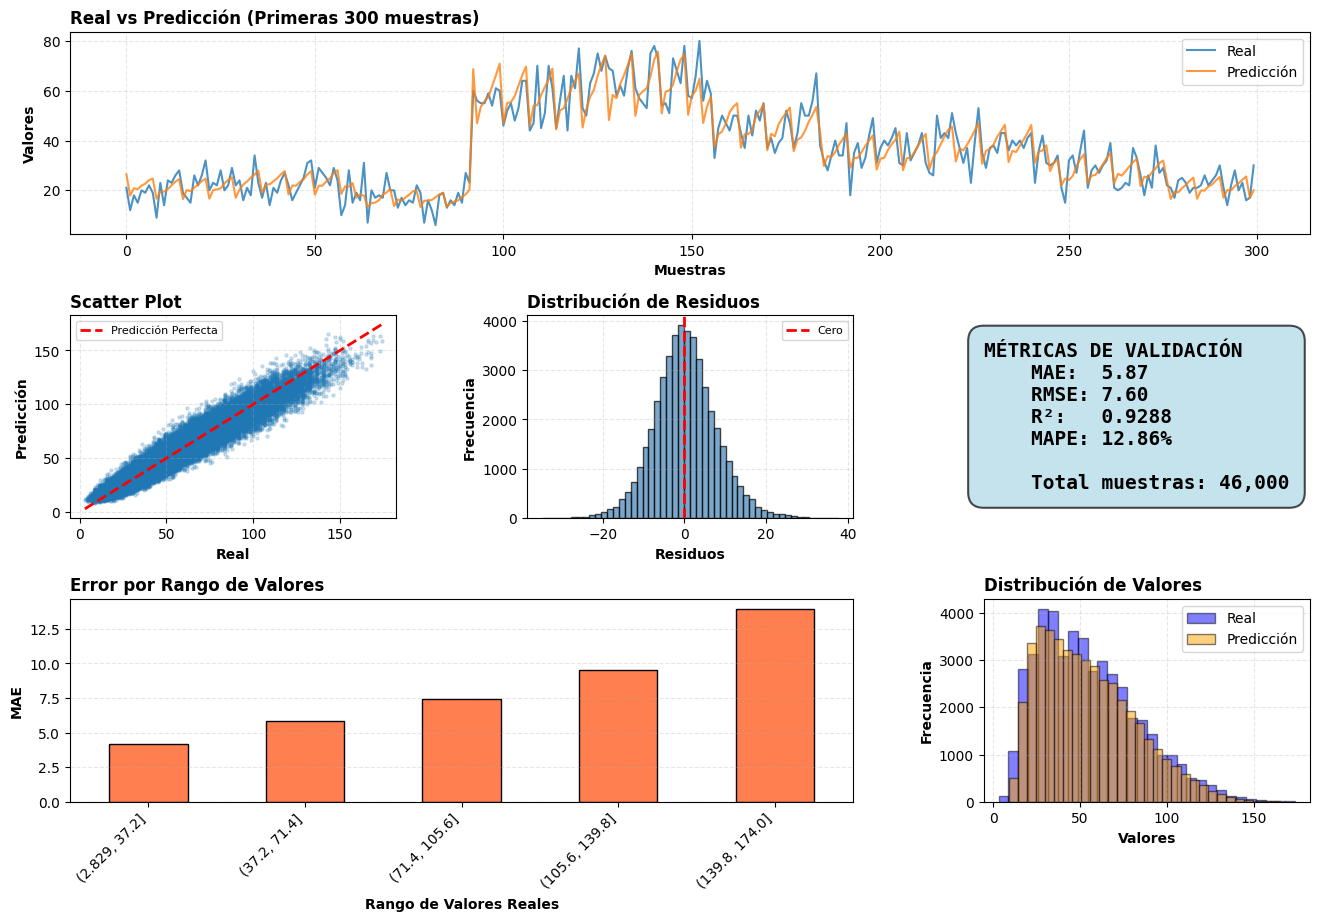

In [41]:
validation_dashboard.plot_dashboard(y_val.values, val_pred)


In [42]:
joblib.dump(model, 'LGBM_Demand_Forecaster.pkl')
print('✅ Modelo LightGBM Forecaster guardado correctamente')

✅ Modelo LightGBM Forecaster guardado correctamente


---
### Generar predicciones a futuro utilizando el modelo guardado
Se realizará una predicción de 31 días (1 mes) a partir de la última fecha disponible en el dataset original.

In [43]:
with open('LGBM_Demand_Forecaster.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
future_df = future_predictions.generate_future_predictions(
    train=train_df,
    test=test_df,
    model=loaded_model,
    group_cols=['store', 'item'], 
    target_col='sales',
    n_days_ahead=31
)


Using only train
Last date: 2017-12-31 00:00:00
Historical: 913,000 rows
Prediction from 2018-01-01 00:00:00 to 2018-01-31 00:00:00
Total predictions to make: 15,500
✅ Calendar features created: day_of_week, is_weekend, month, year, day, week_of_year, quarter, month_start, month_end
✅ Lag features created: ['lag_1', 'lag_7', 'lag_14', 'lag_28']
✅ Rolling features created: ['roll7', 'roll28']
✅ Converted to categorical: ['store', 'item']
✅ Downcasted 6 numeric columns to float32

✅ Predictions:
Total: 15,500
Range: [8.00, 113.00]
Mean: 37.18
Total estimated sales: 576302.00


In [44]:
display(future_df.head(20))

,date,store,item,predicted_sales
1826,2018-01-01,1,1,12
1827,2018-01-02,1,1,14
1828,2018-01-03,1,1,14
1829,2018-01-04,1,1,15
1830,2018-01-05,1,1,16
1831,2018-01-06,1,1,17
1832,2018-01-07,1,1,18
1833,2018-01-08,1,1,13
1834,2018-01-09,1,1,14
1835,2018-01-10,1,1,14


A continuación se arma un dataset personalizado para utilizar en el dashboard de Looker Studio

In [45]:
dashboard_data = future_predictions.dataset_for_dashboard(
    train=train_df,
    test=test_df,
    future_predictions=future_df
)

✅ Dataset for dashboard:
Total rows: 928,500
Historic: 913,000
Forecast: 15,500


In [46]:
dashboard_data.head(20)

,date,store,item,type,actual_sales,predicted_sales
0,2013-01-01,1,1,historical,13,None
1,2013-01-02,1,1,historical,11,None
2,2013-01-03,1,1,historical,14,None
3,2013-01-04,1,1,historical,13,None
4,2013-01-05,1,1,historical,10,None
5,2013-01-06,1,1,historical,12,None
6,2013-01-07,1,1,historical,10,None
7,2013-01-08,1,1,historical,9,None
8,2013-01-09,1,1,historical,12,None
9,2013-01-10,1,1,historical,9,None


In [47]:
dashboard_data_path = Path('dataset/dashboard_data.csv')

if dashboard_data_path.exists():
    print('ℹ️ Data for dashboard already generated')
else:
    dashboard_data.to_csv(dashboard_data_path, index=False)
    print('✅ Data for dashboard generated correctly')
    

ℹ️ Data for dashboard already generated



---

***Autor:*** *Palomares Nicolas*

***Fecha:*** *Noviembre 2025*

### **Información de contacto**

* [Website (Notion)](https://npds.notion.site/NicolasPalomares-DS-29433ae6124e8069ae44caa341ea1f16)

* [LinkedIn](https://www.linkedin.com/in/nicolas-palomares-ds)

* [YouTube](https://www.youtube.com/@NicolasPalomares-ds)

* [GitHub](https://github.com/NicolasPalomaresDS)

![footer](https://i.imgur.com/l2J6fZB.png)